## C - Linear regression with Swyft

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 15 September 2023

**Purpose**: A first non-trivial example with vector-shaped data.

**Key take-away messages**: Low-dimensional linear regression tasks can be performed with standard Swyft functionality and networks.

### Code

In [1]:
import numpy as np
import pylab as plt
import torch
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

We now consider a simple linear regression problem. Our data vector $\mathbf x$ has now length 100, and we consider three model parameters $\mathbf z$ which for the constant, linear and quatractic contribution.

$$ 
x_i = z[0] + z[1]\cdot y_i + z[2] \cdot y_i^2
$$

where $\mathbf y$ is a linear grid.

In [3]:
N = 10_000  # Number of samples
Nbins = 100
z = np.random.rand(N, 3)*2 - 1
y = np.linspace(-1, 1, Nbins)
m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
x = m + np.random.randn(N, Nbins)*0.2

# We keep the first sample as observation, and use the rest for training
samples = swyft.Samples(x = x[1:], z = z[1:])
obs = swyft.Sample(x = x[0], z = z[0])

It is useful to visualize a subset of the training data, as well as our mock observation for which we will perform parameter inference below.

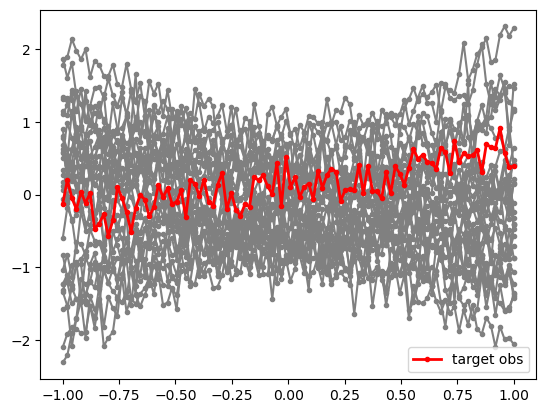

In [4]:
for i in range(30):
    plt.plot(y, samples[i]['x'], marker='.', color='0.5')
plt.plot(y, obs['x'], marker='.', color='r', lw = 2, label = 'target obs')
plt.legend(loc=0)

Inference proceeds now as before, with the only difference that the size of the data vector (`num_features`) is now larger.

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = Nbins, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        return self.logratios(A['x'], B['z'])

trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
dm = swyft.SwyftDataModule(samples)
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 71.2 K
------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/cweniger/Documents/swyft/notebooks/lightning_logs/version_17/checkpoints/epoch=5-step=1500.ckpt


Inference is done as before, now targeting the mock observation from above. We plot the three one-dimensional posteriors side by side.

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


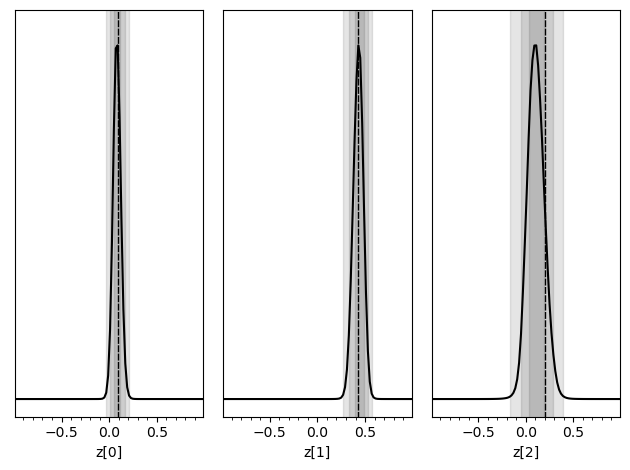

In [6]:
prior_samples = swyft.Samples(z = np.random.rand(100_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(3)], truth=truth)

### Exercises

1. Estimate correlations and make corner plot.

In [7]:
# Results go here

2. Add non-Gaussian noise to the data. For instance, you can use `ngn = np.random.poisson(lam = 3/Nbins, size = (N, Nbins))*5`. This will produce on average 3 strong peaks in the data (a radio astronomer might think of RFI).

- Run the network training again and see that parameter inference still works.
- If you couldn't use a neural net, what would you use instead?



In [8]:
# Results go here